In [8]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
using ForwardDiff
using JuMP
using COSMO
using ECOS
using Random; 

  Activating environment at `~/SSD/Code/TinyMPC/julia/cone_simple/Project.toml`


ΔJ = 595.6418152952101
ΔJ = 2.9792783444281667
ΔJ = 0.0
iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    1.329e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+00
convio = 47.01680822168961
ΔJ = 14672.902957835235
ΔJ = 2777.083365086466
ΔJ = 14.17279899935238
ΔJ = 0.0
  2    1.355e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+01
convio = 29.813217261444287
ΔJ = 39930.40026758821
ΔJ = 72609.78294609301
ΔJ = 2866.6112991576083
ΔJ = 2.4860617604572326
ΔJ = 0.0
  3    1.403e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+02
convio = 14.079706213310454
ΔJ = 10622.107545429375
ΔJ = 121155.11184335523
ΔJ = 972.4363075539004
ΔJ = 2.385795142268762
ΔJ = 0.0
  4    1.469e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+03
convio = 8.699420636610062
ΔJ = 275518.9360845261
ΔJ = -171718.53180575348
ΔJ = 163029.01467027212
ΔJ = 12956.584189470857
ΔJ = 48.608486101729795
ΔJ = 0.0


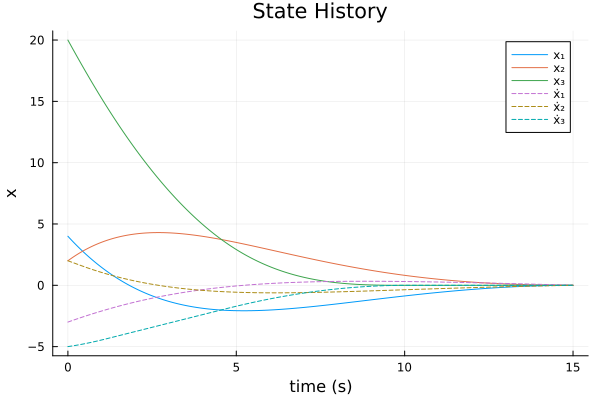

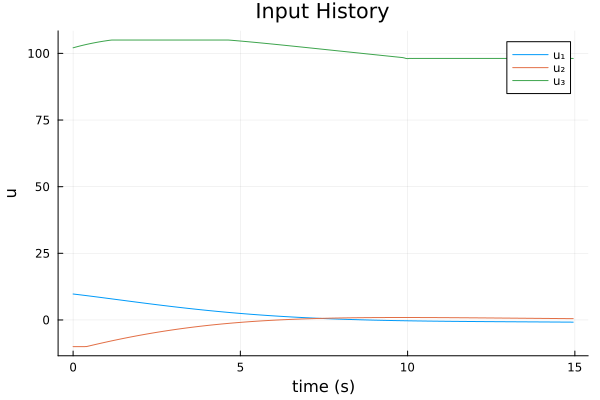

In [69]:
# Let's solve
include("mpc_JuMP.jl")
include("tinyMPC.jl")

affine = 1  # SOLVE AFFINE DYNAMICS

# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
function discrete_dynamics(p::NamedTuple,x,u,k)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0; 
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f*affine
end
nx = 6
nu = 3
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Q = 10e-1*I(nx)
R = 1e-0*I(nu)
Qf = 100*I(nx)

# ground_level = 0.0
gravity = [0; 0; -9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -10.0*ones(nu)
u_max =  105.0*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*1
ncu = 2*nu*1
ncg = 1
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

optimizers = (
    JuMP.optimizer_with_attributes(COSMO.Optimizer,
        "verbose"=>false,
        "eps_abs"=>1e-4,
        "eps_rel"=>1e-4,
        "rho"=>1e-2,
        "scaling"=>0,
        "alpha"=>1.0),
    JuMP.optimizer_with_attributes(ECOS.Optimizer, 
        "verbose"=>false,
        "feastol"=>1e-4,
        "abstol"=>1e-4,
        "reltol"=>1e-4)) 
# trajopt_JuMP1(optimizers[1], params, Xn, Un, A, B, f; warm_start=false)
u_ = mpc(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,verbose=true,ρ=1e0,ρ_max=1e10, ϕ=10.0);

Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

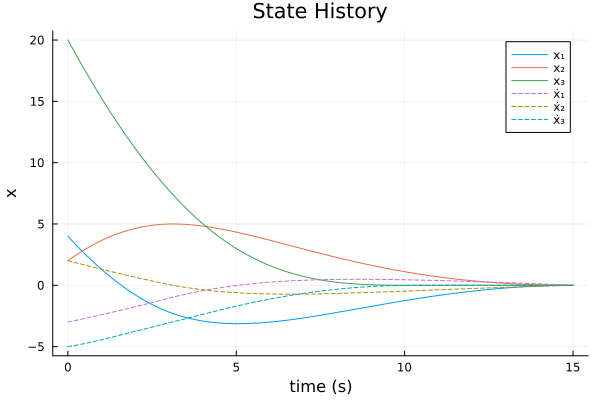

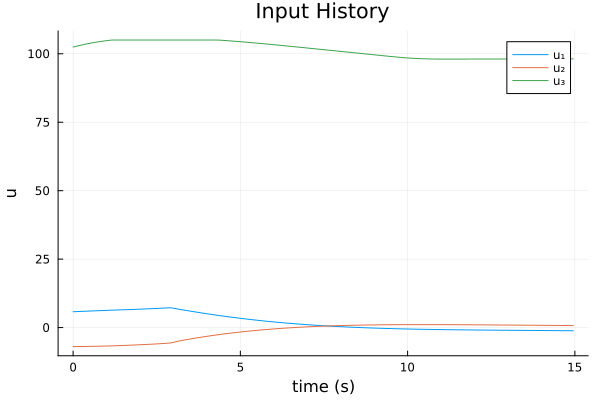

In [47]:
Xtest = [deepcopy(x0) for i = 1:N]
for k = 1:N-1
  Xtest[k+1] = discrete_dynamics(params, Xtest[k], Un[k], k)
end
Xsim_m = mat_from_vec(Xtest)
Usim_m = mat_from_vec(Un)
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

In [22]:
# ---------------------DOUBLE INTEGRATOR--------
function discrete_dynamics(p::NamedTuple,x,u,k)
    # RK4
    A = [1.0  0.0  0.1  0.0;
         0.0  1.0  0.0  0.1;
         0.0  0.0  1.0  0.0;
         0.0  0.0  0.0  1.0]
    B = [0.005  0.0;
         0.0    0.005;
         0.1    0.0;
         0.0    0.1]
    return A*x + B*u
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function ineq_con_u_jac(params,u)
    ForwardDiff.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    ForwardDiff.jacobian(_x -> ineq_con_x(p,_x),x)
end

# here is the script
nx = 4
nu = 2
N = 30
dt = 0.1
t_vec = dt*(0:N-1)
x0 = [0,0,0,0.]
xg = [1,1.,0,0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]
Q = 1e-2*I(nx)
R = 1e-1*I(nu)
Qf = 1*I(nx)

u_min = -2*ones(nu)
u_max =  2*ones(nu)

# state is x y v θ
x_min = -2*ones(nx)
x_max =  2*ones(nx)

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 1
ncu_cone = 0

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [.01*randn(nu) for i = 1:N-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
u_ = mpc(params,X,U,P,p,K,d,Xn,Un; atol=1e-4, max_iters = 20, verbose = true, ρ = 1e2, ρmax = 1e8, ϕ = 10.0);

Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "ẋ₁" "ẋ₂" ],linestyle=[:solid :solid :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

LoadError: MethodError: no method matching mpc(::NamedTuple{(:nx, :nu, :ncx, :ncu, :ncg, :ncu_cone, :μ, :μx, :λ, :λc, :A_cone, :c_cone, :N, :Q, :R, :Qf, :u_min, :u_max, :x_min, :x_max, :Xref, :Uref, :dt, :mc, :mp, :l, :g), Tuple{Int64, Int64, Int64, Int64, Int64, Int64, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Float64}}, Matrix{Int64}, Vector{Float64}, Int64, Diagonal{Float64, Vector{Float64}}, Diagonal{Float64, Vector{Float64}}, Diagonal{Int64, Vector{Int64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Float64, Float64, Float64, Float64, Float64}}, ::Vector{Vector{Float64}}, ::Vector{Vector{Float64}}, ::Vector{Matrix{Float64}}, ::Vector{Vector{Float64}}, ::Vector{Matrix{Float64}}, ::Vector{Vector{Float64}}, ::Vector{Vector{Float64}}, ::Vector{Vector{Float64}}; atol=0.0001, max_iters=20, verbose=true, ρ=100.0, ρmax=1.0e8, ϕ=10.0)
[0mClosest candidates are:
[0m  mpc(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any; atol, max_iters, verbose, ρ, ρ_max, ϕ) at In[15]:182[91m got unsupported keyword argument "ρmax"[39m

In [18]:
# Enable warm-starting
function trajopt_JuMP1(optimizer, params, X, U, A, B, f; warm_start=true)
  Nh = params.N
  nx = params.nx
  nu = params.nu
  α_max = params.c_cone[3]
  NN = Nh*nx + (Nh-1)*nu
  x0 .= X[1]
  
  inds = reshape(1:(nx+nu)*Nh,nx+nu,Nh)  
  xinds = [z[1:nx] for z in eachcol(inds)]
  uinds = [z[nx+1:end] for z in eachcol(inds)][1:Nh-1]    
  
  model = Model(optimizer)
  
  @variable(model, z[1:NN])  # z is all decision variables (X U)
  if warm_start
      z_ws = zeros(NN,1)
      for j = 1:Nh-1
          z_ws[xinds[j]] .= X[j]
          z_ws[uinds[j]] .= U[j]
      end
      z_ws[xinds[Nh]] .= X[Nh]
      set_start_value.(z, z_ws)
  end
  
  P = zeros(NN, NN)
  q = zeros(NN, 1) 
  # Cost function   
  for j = 1:Nh-1
      P[(j-1)*(nx+nu).+(1:nx),(j-1)*(nx+nu).+(1:nx)], q[(j-1)*(nx+nu).+(1:nx)], 
      P[(j-1)*(nx+nu)+nx.+(1:nu),(j-1)*(nx+nu)+nx.+(1:nu)], q[(j-1)*(nx+nu)+nx.+(1:nu)] = stage_cost_expansion(params, j)
  end    
  P[end-nx+1:end,end-nx+1:end], q[end-nx+1:end] = term_cost_expansion(params)
  @objective(model, Min, 0.5*dot(z,P,z) + dot(q,z))

  # Dynamics Constraints
  for k = 1:Nh-1
      @constraint(model, A*z[xinds[k]] .+ B*z[uinds[k]] .+ f .== z[xinds[k+1]])
  end
  
  # Initial condition 
  @constraint(model, z[xinds[1]] .== x0)
  
#   Thrust angle constraint
  if params.ncu_cone > 0 
    for k = 1:Nh-1
        u1,u2,u3 = z[uinds[k]]
        @constraint(model, [α_max * u3, u1, u2] in JuMP.SecondOrderCone())
    end
  end
  
  # State Constraints
  if params.ncx > 0 
    for k = 1:Nh
      @constraint(model, z[xinds[k]] .<= params.x_max)
      @constraint(model, z[xinds[k]] .>= params.x_min)
    end  
  end

  # Input Constraints
  if params.ncu > 0 
    for k = 1:Nh-1
      @constraint(model, z[uinds[k]] .<= params.u_max)
      @constraint(model, z[uinds[k]] .>= params.u_min)
    end  
  end

  # Goal constraint
  if params.ncg > 0 
      @constraint(model, z[xinds[N]] .== zeros(nx))
  end    

  optimize!(model)   
  termination_status(model) == INFEASIBLE && print("Other solver says INFEASIBLE\n")
  for j = 1:Nh-1
      X[j] .= value.(z[xinds[j]]) 
      U[j] .= value.(z[uinds[j]]) 
  end    
  X[Nh] .= value.(z[xinds[Nh]])
  # display(MOI.get(model, MOI.SolveTimeSec()))
  return X
end

trajopt_JuMP1 (generic function with 1 method)

In [23]:
@show params.λ'*X[N]
X[N]
# params.μx
convio = 0.0
if params.ncx > 0
  for k = 1:N
    hxv = ineq_con_x(params,X[k])
    mask = eval_mask(μx[k],hxv)
    # update dual
    convio = max(convio,norm(hxv + abs.(hxv),Inf)) 
    @show params.μx[k]'*hxv         
  end
end

(params.λ)' * X[N] = 0.0


For TrajOpt, it needs more tricks to get better results:
- Hessian of the projection => better approximation (done)
- Scaling between conic constraints and other ones (1/rho, Zac did not buy it)
- Solution polishing?

Maybe, we don't care about TrajOpt problem, except from a good initial guess, there is nothing we can tune to get better performance. How about reset mpc?

In [49]:
# Check conic violation
convio = 0.0
for k = 1:30
    Uc = cone_u(params, Un[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end
Xref .= Xn;
Uref .= Un;

4.9410292201878665

4.878532262610005

4.814945860696705

4.75272752534776

4.689249962291745

4.62760174076854

4.565410227238498

4.502840180736467

4.359756973707226

4.191876172919827

4.024081794465294

3.860167516813778

3.695481504957014

3.5304098263083503

3.3683257576047847

3.2068714282334447

3.0455079216827965

2.8860729266353164

2.7271633983813253

2.5680559832584766

2.4112241449534455

2.254914760010424

2.1007484699137855

1.9484924273196995

1.8042069806159216

1.6594977806361673

1.5151489609392854

1.372594458837563

1.230429640028797

1.0886829232801336

In [37]:
### MPC style with other solver ###
include("mpc_JuMP.jl")

Nsim = 301
Nh = 21
t_vec = dt*(0:Nsim-1)

x0 = [4, 2, 20, -3, 2, -5.0]  # initial plan
# x0 = [5, 2, 21, -3, 2, -5.0]  # change this!
# x0 = [4.4, 2.2, 20.2, -3.03, 2.02, -5.05]

xg = [0,0,0,0,0,0.0]
Q = 1000e-1*I(nx)
R = 1e-0*I(nu)
Qf = 100*I(nx)

# ground_level = 0.0
gravity = [0; 0; -9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -10.0*ones(nu)
u_max =  105.0*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 1
ncu_cone = nu*1; 
cone_scale = 1e-2  # very fragile for each problem

μ = [zeros(ncu) for i = 1:Nh-1]   # input constraints
μx = [zeros(ncx) for i = 1:Nh]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:Nh-1]   # goal constraint

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone,
    c_cone = c_cone,
    N = Nh,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    g = 9.81,
);

Xhist = [deepcopy(x0) for i = 1:Nsim]
Uhist = deepcopy(Uref)
# previous iterate
X = [deepcopy(x0) for i = 1:Nh]
U = [-mass * gravity for k = 1:Nh-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:Nh]   # cost to go quadratic term
p = [zeros(nx) for i = 1:Nh]      # cost to go linear term
d = [zeros(nu) for i = 1:Nh-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:Nh-1] # feedback gain

optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
    "verbose"=>false,
    "eps_abs"=>1e-4,
    "eps_rel"=>1e-4,
    "rho"=>1e-2,
    "scaling"=>0,
    "alpha"=>1.0)
Random.seed!(1);
for i = 1:Nsim-Nh-1
    params1 = (; params..., Uref = Uref[i:Nh+i-1], Xref = Xref[i:Nh+i])  # update ref
    
    pos_norm = norm(Xhist[i][1:3], Inf) / 100 # 1% noise
    vel_norm = norm(Xhist[4:6], Inf) / 1e6 # 1ppm noise
    noise_pos = randn(3)
    noise_vel = randn(3)
    Xhist[i] += [noise_pos * pos_norm; noise_vel * vel_norm]
    X[1] .= Xhist[i] 
    
    # Uhist[i] = mpc_JuMP(optimizer, params1, X, U, A, B, f; warm_start=false)
    
    # X = [Xhist[i] for i = 1:Nh]  # reset, avoid warm-staring
    # U = [-mass * gravity for k = 1:Nh-1]
    Uhist[i] = mpc(params1,X,U,P,p,K,d,Xn,Un;atol=1e-1,max_iters = 10,verbose = false,ρ = 1e1,ρ_max=1e8, ϕ = 10.0) 
    
    Xhist[i+1] = discrete_dynamics(params1,Xhist[i],Uhist[i],i)  # dynamics
end

ΔJ = 1582.5904460004133
ΔJ = 0.0
ΔJ = 16.369895178780098
ΔJ = 0.0
ΔJ = 0.8694049681030833
ΔJ = 79.56928721361032
ΔJ = 0.0
ΔJ = 3534.95092236628
ΔJ = 0.0
ΔJ = 28557.573701123467
ΔJ = 0.0
ΔJ = -387558.2391447077
ΔJ = 0.0
ΔJ = -1.8811066592717826e8
ΔJ = 0.0
ΔJ = 2.3064187421885734e9
ΔJ = 0.0
Our solver reachs MAX PENALTY
ΔJ = -1.3258492266318885e15
ΔJ = 0.0
ΔJ = 1.0356662427607581e15
ΔJ = 0.0
ΔJ = 3.946061772070263e14
ΔJ = 0.0
ΔJ = 5.5474481708292734e13
ΔJ = 0.0
ΔJ = 4.496949288498689e13
ΔJ = 0.0
ΔJ = 3.12740717274159e13
ΔJ = 0.0
ΔJ = 4.051625077064295e12
ΔJ = 0.0
ΔJ = -7.848774209887847e11
ΔJ = 0.0
Our solver reachs MAX PENALTY
ΔJ = -4.072059909053084e19
ΔJ = 0.0
ΔJ = 3.0676597627934745e19
ΔJ = 0.0
ΔJ = 1.1161050399297243e19
ΔJ = 0.0
ΔJ = 4.2526019294210515e17
ΔJ = 0.0
ΔJ = 1.604051691021893e17
ΔJ = 0.0
ΔJ = 1.095896126055081e16
ΔJ = 0.0
ΔJ = 4.648670012639724e14
ΔJ = 0.0
ΔJ = 3.673973514288135e13
ΔJ = 0.0
Our solver reachs MAX PENALTY
ΔJ = -4.1234666478902664e16
ΔJ = 0.0
ΔJ = 1.10436748

1. COSMO gives better tracking results
2. Ours always need warm-start

In [38]:
# Check conic violation
convio = 0.0
for k = 1:30
    Uc = cone_u(params, Uhist[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end

0.01596301606303996

-0.8258473375177928

5803.311954754068

619.7543249610326

607.1371169685351

581.1192162411446

556.7580415961096

537.192840396665

512.8643397153608

487.37181735292336

7616.50979308253

236.7050649441776

273.06382553555693

328.43867188186283

4322.213353066045

841.6131558488033

869.7666508568714

863.719531325726

839.4414108625655

803.3228489143376

4069.046212833464

948.3723143264674

965.2176687615396

945.3776237613913

12608.343184292615

140975.41974050773

-5068.419222304642

121508.13548266397

1939.5804163991604

2655.314670716063

traj_error = maximum(norm.(e_sim_m, Inf)) = 46660.03911861732


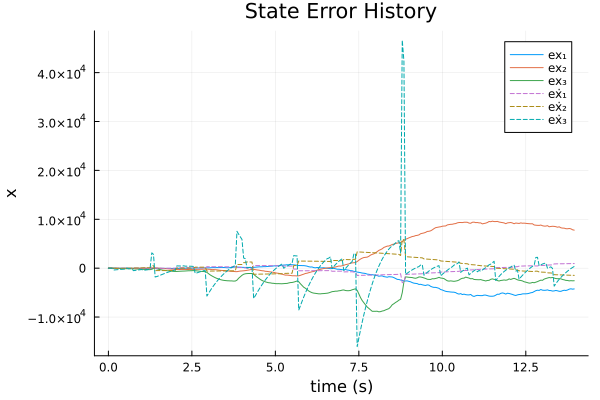

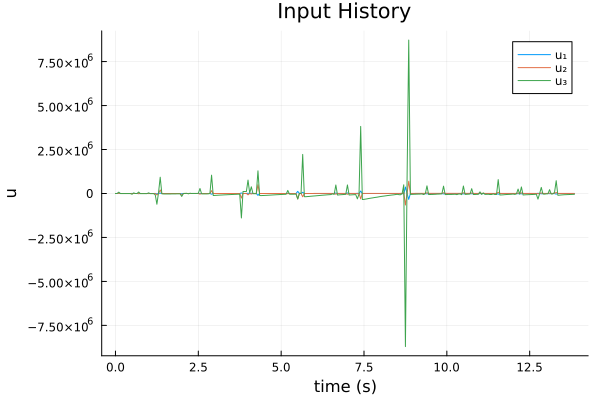

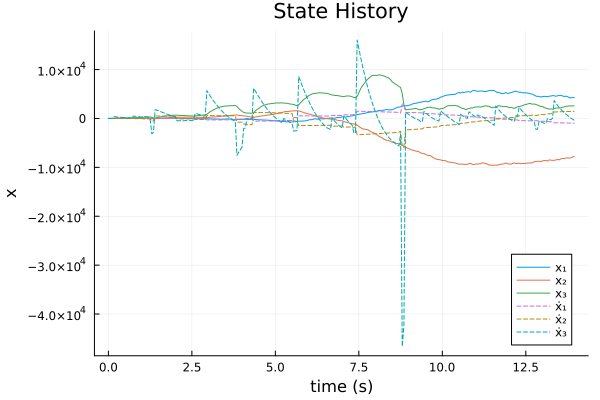

In [39]:
Xsim_m = mat_from_vec(Xhist[1:end-Nh])
Usim_m = mat_from_vec(Uhist[1:end-Nh-1])
e_sim_m = mat_from_vec(Xref[1:end-Nh]-Xhist[1:end-Nh])
@show traj_error = maximum(norm.(e_sim_m, Inf))
display(plot(t_vec[1:end-Nh],e_sim_m',label = ["ex₁" "ex₂" "ex₃" "eẋ₁" "eẋ₂" "eẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash], 
             title = "State Error History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-Nh-2],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))
display(plot(t_vec[1:end-Nh],Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))